[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/Time-Series-Modelling/blob/main/Transformer-Encoder.ipynb)

# M1 : Create self attention from scratch
Currently working on this and trying to implement transformers encoder from scratch in pytorch, this is not yet functional code

### Multi-Head Attention
This will be used for both self and cross multi head attention                                                      

Attention:                                                                                                                                                                                                                                                                               
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.                                                                                                                                                                                                                                                                                           

We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.                                                                                                         
<img width="220px" src="ModalNet-19.png">

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$                                                                                                                                                                                                        
                                                                                                                                                                     

In [ ]:
# for implementing multi headed attention we will first have to implement attention and the we can make copies of this
# to implement multi headed attention
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

The two most commonly used attention functions are additive attention [(cite)](bahdanau2014neural), and dot-product (multiplicative) attention.  Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.  While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.                                                                                             

                                                                        
While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [(cite)](DBLP:journals/corr/BritzGLL17). We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients  (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.          

                                                                                                                                                                                                                                                                                                                                                                     
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Instead of performing a single attention function with $d_{\text{model}}$-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively.                                                                                                                                                                                                   
On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values:

<img width="270px" src="ModalNet-20.png">
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.                                                                                                                                                                                                                                                                                             
    
    
   
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.                                                                                                                                                                                                                                                        
   

   
In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.   

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### Positional Encoding                                                                                      

                                       
in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed [(cite)](JonasFaceNet2017).

In this work, we use sine and cosine functions of different frequencies:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
$$                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \\                                                                                                                                                                                                                                                                                                                                                                                                                                      
    PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})                                                                                                                                                                                                                                                                                                                                                                                                                                       
$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$.
                                                                                                                                                                                                                                                    


In [ ]:
"Implement the PE function."

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

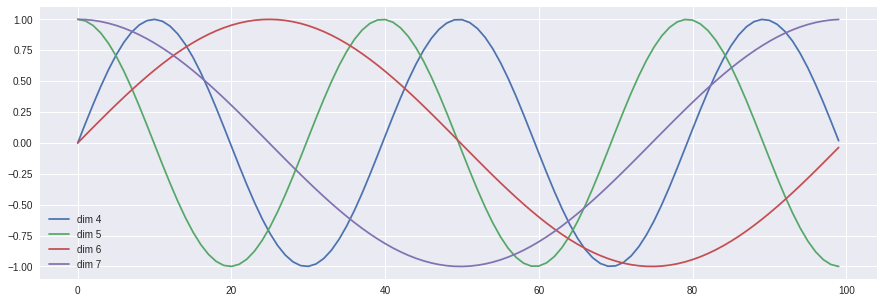

In [ ]:
# The positional encoding will add in a sine wave based on position.The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

We also experimented with using learned positional embeddings [(cite)](JonasFaceNet2017) instead, and found that the two versions produced nearly identical results.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.    

### Layer Norm  


In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](srivastava2014dropout) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

### Residual Connections

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))

### Position-wise Feed-Forward Networks                                                                                                                                


The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$.

In [ ]:
# In addition to attention sublayers, we know that transformer encoder and transformer decoder both has a FFNN in its hidden layer which is applied to each position separately
# Here we will define that as a 2 hidden layer architecture

class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

### Transformer Encoder

In [ ]:
# defining the transformer encoder which is made up of two sublayers , multi-headed self-attention layer and feed forward layer (defined below)"
class EncoderLayer(nn.Module):

  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

In [ ]:
# Defining the encoder i.e. multiple transformer encoders stacked togethere - we will stack N = 6
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [ ]:
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),


# M2 : Using Pytorch Self Attention Layer

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, # the embedding dimensions
                                                    num_heads=num_heads, # number of attention heads
                                                    dropout=attn_dropout, #wheather or not to use dropout
                                                    batch_first=True) # does our batch dimension come first?

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [ ]:
class MLPBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
class TransformerEncoderBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x =  self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

# M3 : Using Pytorch Transformer Encoder Layer
Pytorch has already done the above hard work for us and given us it form of a layers, simple one line code it is!!

In [ ]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)

# now stacking the above transformer encoder layer 12 times
transformer_encoder = nn.TransformerEncoder( encoder_layer=transformer_encoder_layer, num_layers=12)

# M4

In [ ]:
class Attention(nn.Module):


   def __init__(self):
       super().__init__()
       self.n_heads = 12
       self.hidden_size = 768
       self.head_dim = 64


       self.att_dim = self.n_heads * self.head_dim


       # QKV projection for the input
       self.qkv_proj = nn.Linear(self.hidden_size, 3 * self.att_dim, bias=True)
       self.output_proj = nn.Sequential( nn.Linear(self.att_dim, self.hidden_size))


   def forward(self, x):
       #  Converting to Attention Dimension
       ######################################################
       # Batch Size x Number of Patches x Dimension
       B, N = x.shape[:2]
       # Projecting to 3*att_dim and then splitting to get q, k v(each of att_dim)
       # qkv -> Batch Size x Number of Patches x (3* Attention Dimension)
       # q(as well as k and v) -> Batch Size x Number of Patches x Attention Dimension
       q, k, v = self.qkv_proj(x).split(self.att_dim, dim=-1)
       # Batch Size x Number of Patches x Attention Dimension
       # -> Batch Size x Number of Patches x (Heads * Head Dimension)
       # -> Batch Size x Number of Patches x (Heads * Head Dimension)
       # -> Batch Size x Heads x Number of Patches x Head Dimension
       # -> B x H x N x Head Dimension
       q = rearrange(q, 'b n (n_h h_dim) -> b n_h n h_dim', n_h=self.n_heads, h_dim=self.head_dim)
       k = rearrange(k, 'b n (n_h h_dim) -> b n_h n h_dim', n_h=self.n_heads, h_dim=self.head_dim)
       v = rearrange(v, 'b n (n_h h_dim) -> b n_h n h_dim', n_h=self.n_heads, h_dim=self.head_dim)
       #########################################################


       # Compute Attention Weights
       #########################################################
       # B x H x N x Head Dimension @ B x H x Head Dimension x N
       # -> B x H x N x N
       att = torch.matmul(q, k.transpose(-2, -1)) * (self.head_dim ** (-0.5))
       att = torch.nn.functional.softmax(att, dim=-1)
       #########################################################


       # Weighted Value Computation
       #########################################################
       #  B x H x N x N @ B x H x N x Head Dimension
       # -> B x H x N x Head Dimension
       out = torch.matmul(att, v)
       #########################################################


       # Converting to Transformer Dimension
       #########################################################
       # B x N x (Heads * Head Dimension) -> B x N x (Attention Dimension)
       out = rearrange(out, 'b n_h n h_dim -> b n (n_h h_dim)')
       #  B x N x Dimension
       out = self.output_proj(out)
       ##########################################################


       return out


class TransformerLayer(nn.Module):


   def __init__(self):
       super().__init__()
       self.att_norm = nn.LayerNorm(768, elementwise_affine = False, eps = 1E-6)
       self.ff_norm = nn.LayerNorm(768, elementwise_affine = False, eps = 1E-6)
       self.attn_block = Attention()
       self.mlp_block = nn.Sequential( nn.Linear(768, 4 * 768), nn.GELU(approximate='tanh'), nn.Linear(4 * 768, 768))


   def forward(self, x, condition):
       attn_norm_output = self.att_norm(x)
       out = x + self.attn_block(attn_norm_output)
       mlp_norm_output = self.ff_norm(out)
       out = out + self.mlp_block(mlp_norm_output)
       return out

# M5

In [ ]:
import math
import torch
import torch.nn.functional as F

def scaled_dot_product_attention(q, k, v, mask=None):
    # Let q,k,v.size()=[3,2]
    
    d_k = q.size(-1)  # Scaling value.
    
    attn_logits = torch.matmul(q, k.transpose(-2, -1))  # [3, 2] x [3, 2]->[2, 3] = [3, First matmul step.

    attn_logits = attn_logits / math.sqrt(d_k)  # Scaling step.
    
    if mask is not None:  # Optional masking step.
        attn_logits = attn_logits.masked_fill(mask==0, -9e-15)  # Smaller the mask value better.
    
    attn_logits = F.softmax(attn_logits, dim=-1)  # Softmax step.
    
    result = torch.matmul(attn_logits, v)  # [3, 3] x [3, 2] = [3, 2]. Softmax step.
    
    return result

if __name__ == "__main__":
    q = torch.randn(3, 2)
    k = torch.randn(3, 2)
    v = torch.randn(3, 2)
    
    attention = scaled_dot_product_attention(q, k, v)
    print(attention.size())